In [ ]:
from typing import Generic, Optional, Tuple, List, Callable, Iterable, Mapping

import numpy as np
from torchvision.models import resnet50
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as T
import utils
from utils import debugt, debugs, debug

torch.hub.set_dir('torch_cache')
import fishdetr_batchboy as detr
import contextlib
from generators import TorchStereoDataset
import re
from matplotlib import pyplot as plt
import plotly.express as px

import sys
sys.path.append('./detr_custom/')
from models.matcher import HungarianMatcher
from models.detr import SetCriterion
import os

In [ ]:
debugt = utils.reloader(debugt)

In [ ]:
utils.seed_everything(42069)

try:
    device = utils.pytorch_init_janus_gpu()
    print(f'Using device: {device} ({torch.cuda.get_device_name()})')
    print(utils.get_cuda_status(device))
except AssertionError as e:
    print('GPU could not initialize, got error:', e)
    device = torch.device('cpu')
    print('Device is set to CPU')

In [4]:
DATA_DIR = '/mnt/blendervol/leftright_left_data'
TABLE = 'bboxes_std'
BATCH_SIZE = 4

In [5]:
utils.reloader(detr)

traingen = TorchStereoDataset(DATA_DIR, TABLE, shuffle=False, imgnrs=range(32,32+BATCH_SIZE))

loader = torch.utils.data.DataLoader(
    traingen,
    batch_size=BATCH_SIZE,
    collate_fn=detr.collate
)

X, y = next(iter(loader))
X = detr.img_handler(X, device)
y = detr.label_handler(y, device)

In [6]:
debugs(X[0])

(1, <module>) X[0]: torch.Size([4, 3, 416, 416])


In [7]:
utils.reloader(detr)
def set_momentum(x):
    if isinstance(x, nn.BatchNorm2d):
        x.requires_grad = False
model = detr.FishDETR(freeze_encoder=False).to(device)
model.apply(set_momentum)

Encoder successfully loaded with pretrained weights


FishDETR(
  (encoder): Encoder(
    (backbone): ResNet(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu): ReLU(inplac

In [8]:
@utils.interruptable
def train(model, X, y, epochs: int=1):        
    weight_dict = {'loss_ce': 1, 'loss_bbox': 1 , 'loss_giou': 1}
    losses = ['labels', 'boxes', 'cardinality']
    matcher = HungarianMatcher()
    criterion = SetCriterion(6, matcher, weight_dict, 0.5, losses).to(device)
    optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4)
    
    model.train()
    def bn_eval(x):
        if isinstance(x, nn.BatchNorm2d):
            x.eval()
    criterion.train()
    
    for epoch in range(1,epochs+1):
        output, loss = model.train_on_batch(X, y, criterion, optimizer)
        loss: torch.Tensor
        if not epoch % 10:
            print(loss.item())
    return output

output = train(model, X, y, 800)

2.8805627822875977
1.9677512645721436
1.6017076969146729
1.1915345191955566
0.9605687856674194
1.1059885025024414
0.9821648597717285
1.0160853862762451
0.9224207401275635
0.8833960294723511
0.7011101245880127
0.7258255481719971
0.7441396713256836
0.7199459671974182
0.6247668862342834
0.7448043823242188
0.7159554958343506
0.6626294851303101
0.5454171895980835
0.5122224688529968
0.5177566409111023
0.4513455629348755
0.3521854877471924
0.30806422233581543
0.32931283116340637
0.2902510464191437
0.30373650789260864
0.2489105761051178
0.18112772703170776
0.21118204295635223
0.2594859302043915
0.20510873198509216
0.14866749942302704
0.11886449158191681
0.15167495608329773
0.15043683350086212
0.1566968560218811
0.11991892009973526
0.1468207687139511
0.13623403012752533
0.10654141753911972
0.13795092701911926
0.10552157461643219
0.10083362460136414
0.11372469365596771
0.1136302798986435
0.11676258593797684
0.1376131772994995
0.11060204356908798
0.1240442544221878
0.13285313546657562
0.096393905

In [ ]:
# utils.save_model(model, 'batch_overfit.pth')

In [ ]:
utils.reloader(detr)

In [ ]:
@torch.no_grad()
def bobo(model, X: Tuple[torch.Tensor, torch.Tensor], output):
    model = model.eval()
    X = X.copy()
    X[0], X[1] = X[0][:1], X[1][:1]
    output = model(X)
    boxess = output['pred_boxes']
    logitss = output['pred_logits']
    for left, right, boxes, logits in zip(X[0], X[1], boxess, logitss):
        logits_, boxes_ = detr.postprocess(logits, boxes)
        plot_results(left.cpu().permute((1,2,0)), logits_, boxes_, num2name) 
    
bobo(model, X, None)

AttributeError: 'tuple' object has no attribute 'to'

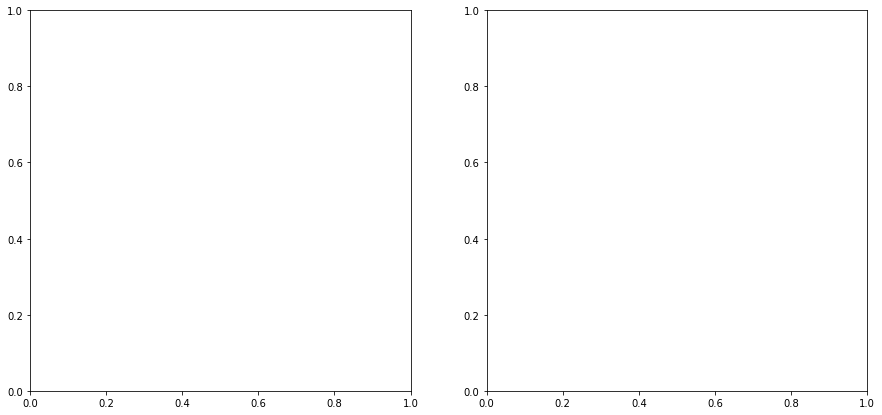

In [9]:
def box_cxcywh_to_xyxy(x: torch.Tensor):
    x_c, y_c, w, h = x.unbind(1)
    b = [(x_c - 0.5 * w), (y_c - 0.5 * h),
         (x_c + 0.5 * w), (y_c + 0.5 * h)]
    return torch.stack(b, dim=1)


def plot_results(img, classes: Iterable, boxes: Iterable, classmap: Optional[Mapping[int, str]]=None, ax: Optional=None):
    if ax is None:
        fig, ax = plt.subplots(figsize=(16,10))
        
    img = np.array(img)
    ax.imshow(img.clip(0,1))
    
    if len(boxes) != 0:
        h, w = img.shape[:2]
        boxes = box_cxcywh_to_xyxy(boxes)
        boxes[:,[0,2]] *= w
        boxes[:,[1,3]] *= h
        
        for cls, (xmin, ymin, xmax, ymax) in zip(classes, boxes):
            ax.add_patch(plt.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin,
                                       fill=False, color='cyan', linewidth=3))
            try:
                strcls = classmap[int(cls)]
            except:
                strcls = str(int(cls))
                    
            ax.text(xmin, ymin, strcls, fontsize=11, bbox=dict(facecolor='cyan', alpha=0.9))
    
    if ax is None:
        ax.axis('off')
        plt.show()
        
    return ax


@torch.no_grad()
def eval_model(model, X: Tuple[torch.Tensor, torch.Tensor], classmap: Optional[Mapping[int, str]]=None, ax: Optional=None):
    model.eval()
    
    output = model(X)
    boxes = output['pred_boxes'][0]
    logits = output['pred_logits'][0]

    logits_, boxes_ = detr.postprocess(logits, boxes, thresh=0.1)

    plot_results(img[0][0].cpu().numpy().transpose((1,2,0)), logits_, boxes_, classmap, ax=ax)
        
        
def eval_compare_model(model: nn.Module, gen: Iterable, index: int=0, classmap: Optional[Mapping[int, str]]=None):
    x, y = gen[index]
    fig, axes = plt.subplots(1,2,figsize=(15,7))
    eval_model(model, detr.img_handler([x])[0], classmap, axes[0])
    plot_results(x[0][0].cpu().numpy().transpose((1,2,0)), y['labels'], y['boxes'], classmap, axes[1])
    axes[0].set_title('Predicted')
    axes[1].set_title('Real')
    

num2name = eval(open(os.path.join(DATA_DIR,"metadata.txt"), 'r').read())
model.eval()
for i in range(BATCH_SIZE):
    eval_compare_model(model, traingen, index=i, classmap=num2name)
    plt.show()
    